## Imports

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as settings
import pandas as pd
import yaml
import warnings
warnings.filterwarnings('ignore')

In [31]:
with open ('trainfile_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

## Splits Data

In [32]:
df = pd.read_csv(config['training_file'])

In [33]:
#repleace the infinities with 0
df.replace([np.inf, -np.inf], 0, inplace=True)

In [42]:
df.shape

(264, 89)

In [35]:
df[config['target']]=df[config['target']].map({'normal': 0, 'abnormal': 1})
df[config['target']].value_counts()


BIIICss
0    190
1     74
Name: count, dtype: int64

In [36]:
columns_to_drop = ['img_name', 'ThalamusDiameter', 'gestage', 'birthweight', 'Language Ability']
columns_to_drop = [col for col in columns_to_drop]
df.drop(columns=columns_to_drop, inplace=True)

In [37]:
df = df[df[config['target']].notna()]

To deal with imbalanced data

In [38]:
from imblearn.over_sampling import SMOTE

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [40]:
columns_to_drop = ['BIIICss', 'BIIIRss', 'BIIIEss']
columns_to_drop = [col for col in columns_to_drop]

X = df.drop(columns_to_drop, axis=1)
y = df[config['target']]
print(f'The target is {config["target"]}')

The target is BIIICss


In [41]:
print(f'There are {X.shape[0]} samples and {X.shape[1]} features')

There are 264 samples and 86 features


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
sm = SMOTE(random_state=42,k_neighbors=3)
# sampling_strategy=2 means that we want to have twice as many positive instances as negative instances
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Checking the new class distribution
print(f'Before SMOTE: {sum(y_train == 1)} positive instances and {sum(y_train == 0)} negative instances.')
print(f'After SMOTE: {sum(y_train_res == 1)} positive instances and {sum(y_train_res == 0)} negative instances.')


Before SMOTE: 56 positive instances and 155 negative instances.
After SMOTE: 155 positive instances and 155 negative instances.


In [13]:
X_train = X_train_res
y_train = y_train_res

In [14]:
# Scale the data
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegressionCV

In [16]:
lr_model = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 10),
    cv=10, #change this to larger number
    penalty='elasticnet',
    scoring='average_precision',
    solver='saga',
    max_iter=1000,
    random_state=101,
    l1_ratios=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
)

In [17]:
lr_model.fit(scaled_X_train,y_train)

LogisticRegressionCV(Cs=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                     cv=10,
                     l1_ratios=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                1],
                     max_iter=1000, penalty='elasticnet', random_state=101,
                     scoring='average_precision', solver='saga')

In [18]:
print('Best C:', lr_model.C_)
print('Best L1 Ratio:', lr_model.l1_ratio_)

Best C: [21.5443469]
Best L1 Ratio: [0]


In [19]:
# Predcit using the model with the best C and L1 ratio
lr_pred = lr_model.predict(scaled_X_test)

Model performance

In [20]:
def evaluate_model(model, scaled_X_test, y_test):
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,roc_auc_score
    y_pred = model.predict(scaled_X_test);
    y_positive_prob = model.predict_proba(scaled_X_test)[:,1]; # Probability of positive class (label 1)
    
    #get confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
    
    #get classification report
    report = pd.DataFrame((classification_report(y_test, y_pred,output_dict=True))).transpose()
    print('\nClassification Report:\n', report)
    
    #calculate AUC
    auc_score = roc_auc_score(y_test, y_positive_prob)
    print(f"\nAUC socre is: {auc_score}\n")
    return y_pred,report,auc_score

In [21]:
def save_results(name,model,scaled_X_test,y_test,target = config['target'], feature_selection = config['feature_selection_method']):
    """ Save accuracy, precision,recall, f1 and auc to the model_scores list
    """
    from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score,precision_score
    y_pred = model.predict(scaled_X_test)
    y_prob = model.predict_proba(scaled_X_test)[:,1]
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    
    results = {
        'Target': target,
        'Feature Selection': feature_selection,
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }
    model_scores.append(results)



Classification Report:
               precision    recall  f1-score    support
0              0.694444  0.714286  0.704225  35.000000
1              0.411765  0.388889  0.400000  18.000000
accuracy       0.603774  0.603774  0.603774   0.603774
macro avg      0.553105  0.551587  0.552113  53.000000
weighted avg   0.598440  0.603774  0.600904  53.000000

AUC socre is: 0.5428571428571429



(array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 0, 0]),
               precision    recall  f1-score    support
 0              0.694444  0.714286  0.704225  35.000000
 1              0.411765  0.388889  0.400000  18.000000
 accuracy       0.603774  0.603774  0.603774   0.603774
 macro avg      0.553105  0.551587  0.552113  53.000000
 weighted avg   0.598440  0.603774  0.600904  53.000000,
 0.5428571428571429)

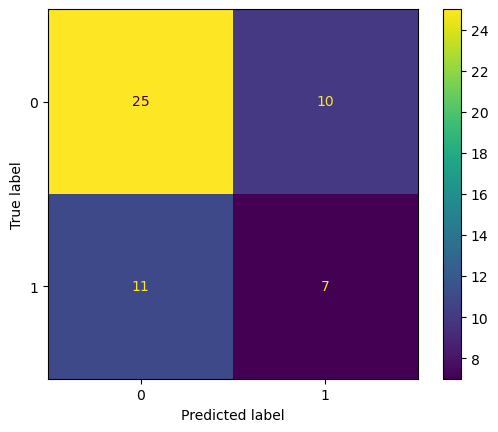

In [22]:
evaluate_model(lr_model, scaled_X_test, y_test)

In [23]:
from sklearn.metrics import RocCurveDisplay

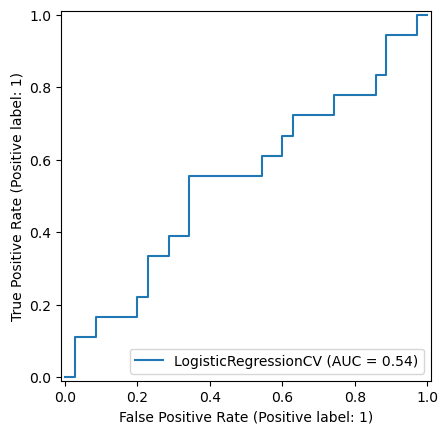

In [24]:
RocCurveDisplay.from_estimator(lr_model, scaled_X_test, y_test)

## K_Nearest_Neighbors

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [26]:
knn_model = KNeighborsClassifier()

In [27]:
knn_model.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [28]:
k_values = list(range(1,20))
param_grid = {'n_neighbors': k_values}

In [29]:
knnCV_model = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=10, scoring='average_precision')

In [30]:
knnCV_model.fit(scaled_X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             scoring='average_precision')

In [31]:
knnCV_model.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

In [32]:
#knnCV_model.cv_results_

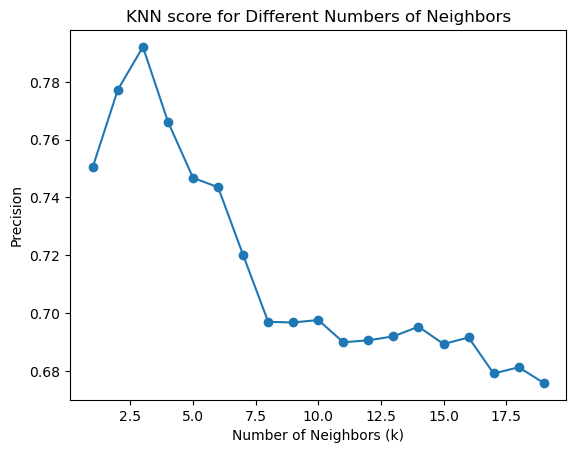

In [33]:
#plotting
mean_scores = knnCV_model.cv_results_['mean_test_score']

# Extract n_neighbors values
n_neighbors = param_grid['n_neighbors']

# Plotting
plt.plot(n_neighbors, mean_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Precision')
plt.title('KNN score for Different Numbers of Neighbors')
plt.show()

Evaluate KNN model


Classification Report:
               precision    recall  f1-score    support
0              0.680000  0.485714  0.566667  35.000000
1              0.357143  0.555556  0.434783  18.000000
accuracy       0.509434  0.509434  0.509434   0.509434
macro avg      0.518571  0.520635  0.500725  53.000000
weighted avg   0.570350  0.509434  0.521876  53.000000

AUC socre is: 0.5158730158730159



(array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0]),
               precision    recall  f1-score    support
 0              0.680000  0.485714  0.566667  35.000000
 1              0.357143  0.555556  0.434783  18.000000
 accuracy       0.509434  0.509434  0.509434   0.509434
 macro avg      0.518571  0.520635  0.500725  53.000000
 weighted avg   0.570350  0.509434  0.521876  53.000000,
 0.5158730158730159)

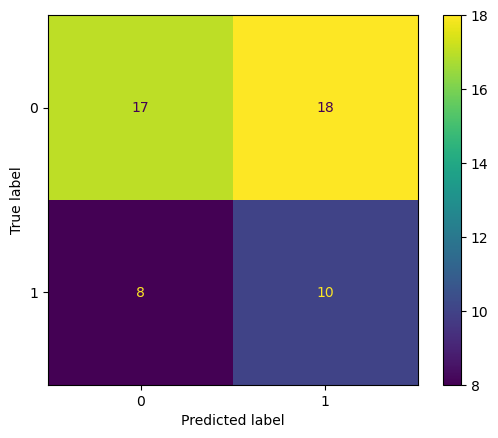

In [34]:
evaluate_model(knnCV_model, scaled_X_test, y_test)

## Suport Vector Machine

In [35]:
from sklearn.svm import SVC

In [36]:
svm_model = SVC()

In [37]:
svm_model.get_params()
param_grid_SVM = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'probability':[True, False]}

In [38]:
svm_modelCV = GridSearchCV(estimator=svm_model, param_grid=param_grid_SVM,scoring='average_precision',cv=10)
svm_modelCV.fit(scaled_X_train, y_train)
svm_modelCV.best_estimator_.get_params()


{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [39]:
print(svm_modelCV.best_params_)

{'kernel': 'rbf', 'probability': True}



Classification Report:
               precision    recall  f1-score    support
0              0.800000  0.457143  0.581818  35.000000
1              0.424242  0.777778  0.549020  18.000000
accuracy       0.566038  0.566038  0.566038   0.566038
macro avg      0.612121  0.617460  0.565419  53.000000
weighted avg   0.672384  0.566038  0.570679  53.000000

AUC socre is: 0.5777777777777777



(array([0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 0, 1]),
               precision    recall  f1-score    support
 0              0.800000  0.457143  0.581818  35.000000
 1              0.424242  0.777778  0.549020  18.000000
 accuracy       0.566038  0.566038  0.566038   0.566038
 macro avg      0.612121  0.617460  0.565419  53.000000
 weighted avg   0.672384  0.566038  0.570679  53.000000,
 0.5777777777777777)

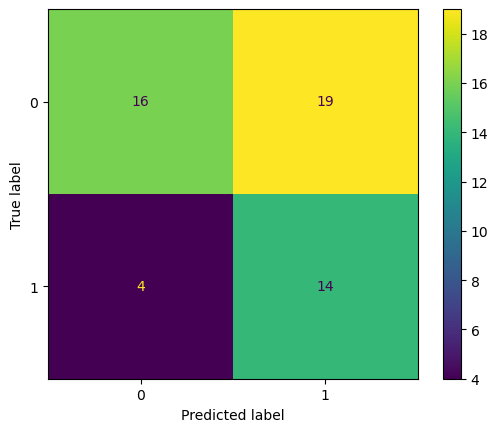

In [40]:
evaluate_model(svm_modelCV, scaled_X_test, y_test)

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
#Change this is the dataset is too large
n_estimators = list(range(1,64,2))
bootstrap = [True, False]
oob_score = [True, False]

param_grid_RF = {'n_estimators': n_estimators,  
                 'bootstrap': bootstrap,
                 'oob_score': oob_score}


In [43]:
rf_model = RandomForestClassifier(random_state=101)

In [44]:
rf_modelCV = GridSearchCV(estimator=rf_model, param_grid=param_grid_RF, cv=10, scoring= 'average_precision')

In [45]:
rf_modelCV.fit(scaled_X_train, y_train)
rf_modelCV.best_params_

{'bootstrap': False, 'n_estimators': 45, 'oob_score': False}

In [46]:
len(n_estimators)

32

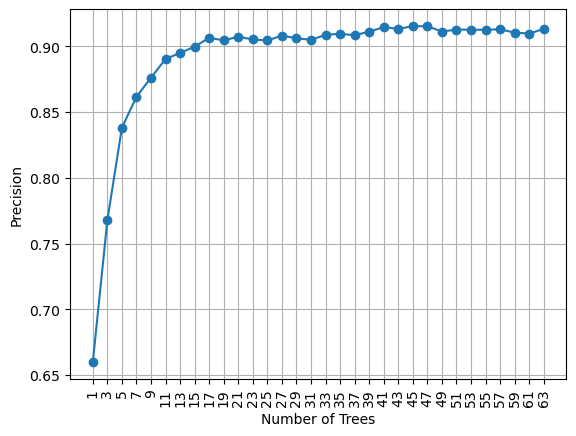

In [47]:
cv_results_df = pd.DataFrame(rf_modelCV.cv_results_)
filtered_results = cv_results_df[(cv_results_df['param_bootstrap'] == False) & (cv_results_df['param_oob_score'] == False)]
plt.plot(filtered_results['param_n_estimators'], filtered_results['mean_test_score'], marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Precision')
plt.xticks(n_estimators, rotation=90)

plt.grid(True)

In [48]:
# Build a model with the best parameters, see the feature importance
rf_best = RandomForestClassifier(n_estimators=13, oob_score=False, bootstrap=False, random_state=101)
rf_best.fit(scaled_X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=13, random_state=101)

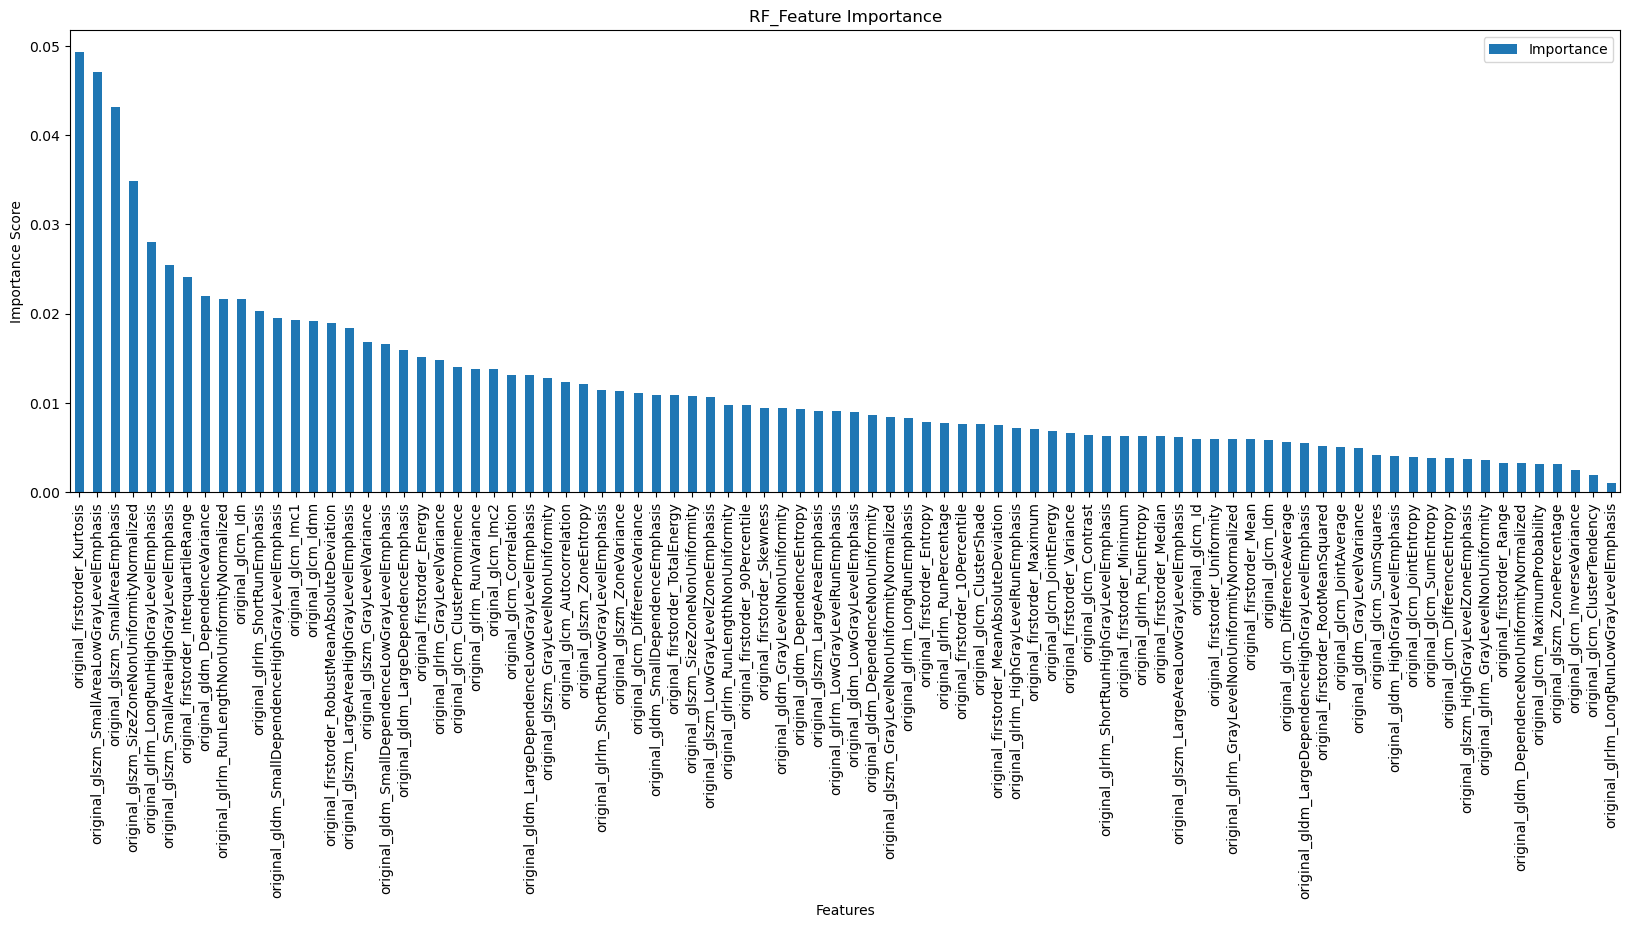

In [49]:
RF_featuredf = pd.DataFrame(rf_best.feature_importances_, index=X.columns, columns=['Importance'])
RF_featuredf = RF_featuredf.sort_values(by='Importance', ascending=False)
RF_featuredf.plot(kind='bar',
                  figsize=(20, 6),
                  title = 'RF_Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


Classification Report:
               precision    recall  f1-score    support
0              0.631579  0.685714  0.657534  35.000000
1              0.266667  0.222222  0.242424  18.000000
accuracy       0.528302  0.528302  0.528302   0.528302
macro avg      0.449123  0.453968  0.449979  53.000000
weighted avg   0.507646  0.528302  0.516553  53.000000

AUC socre is: 0.5373015873015873



(array([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]),
               precision    recall  f1-score    support
 0              0.631579  0.685714  0.657534  35.000000
 1              0.266667  0.222222  0.242424  18.000000
 accuracy       0.528302  0.528302  0.528302   0.528302
 macro avg      0.449123  0.453968  0.449979  53.000000
 weighted avg   0.507646  0.528302  0.516553  53.000000,
 0.5373015873015873)

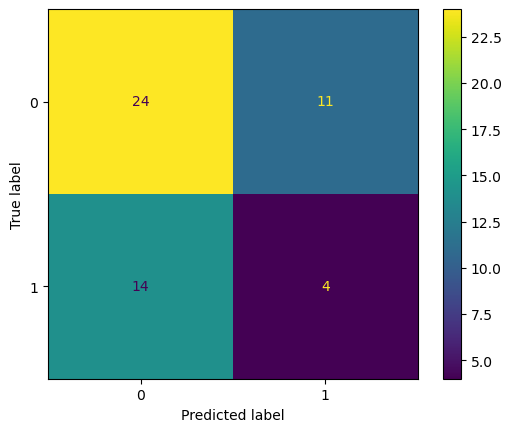

In [50]:
evaluate_model(rf_best, scaled_X_test, y_test)

## AdaBoost

In [51]:
from sklearn.ensemble import AdaBoostClassifier

In [52]:
adaboost_model = AdaBoostClassifier(random_state=101)
adaboost_model.fit(scaled_X_train, y_train)

AdaBoostClassifier(random_state=101)


Classification Report:
               precision    recall  f1-score    support
0              0.636364  0.600000  0.617647  35.000000
1              0.300000  0.333333  0.315789  18.000000
accuracy       0.509434  0.509434  0.509434   0.509434
macro avg      0.468182  0.466667  0.466718  53.000000
weighted avg   0.522127  0.509434  0.515129  53.000000

AUC socre is: 0.5888888888888889



(array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0, 1]),
               precision    recall  f1-score    support
 0              0.636364  0.600000  0.617647  35.000000
 1              0.300000  0.333333  0.315789  18.000000
 accuracy       0.509434  0.509434  0.509434   0.509434
 macro avg      0.468182  0.466667  0.466718  53.000000
 weighted avg   0.522127  0.509434  0.515129  53.000000,
 0.5888888888888889)

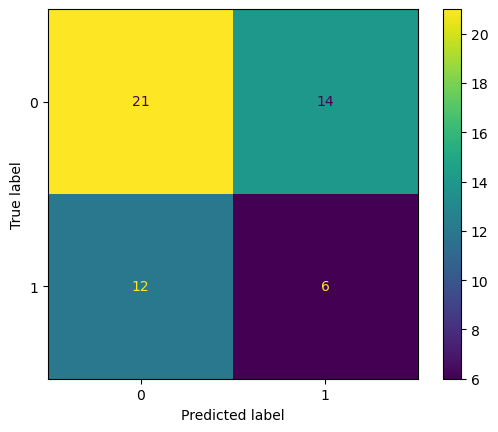

In [53]:
evaluate_model(adaboost_model, scaled_X_test, y_test)

## Gradient Boost

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
param_grid_GB = {'n_estimators':[1,5,10,20,40,60,80,100],
                 'max_depth':[3,4,5,6,7,8,9,10]}

gb_model = GradientBoostingClassifier(random_state=101)
gb_modelCV = GridSearchCV(estimator=gb_model, param_grid=param_grid_GB, cv=10, scoring='average_precision')

In [56]:
gb_modelCV.fit(scaled_X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=101),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [1, 5, 10, 20, 40, 60, 80, 100]},
             scoring='average_precision')

In [57]:
gb_modelCV.best_params_

{'max_depth': 6, 'n_estimators': 80}

In [58]:
gb_model_test = GradientBoostingClassifier(n_estimators=100,max_depth=6,random_state=101)
gb_model_test.fit(scaled_X_train, y_train)


GradientBoostingClassifier(max_depth=6, random_state=101)


Classification Report:
               precision    recall  f1-score    support
0              0.650000  0.742857  0.693333  35.000000
1              0.307692  0.222222  0.258065  18.000000
accuracy       0.566038  0.566038  0.566038   0.566038
macro avg      0.478846  0.482540  0.475699  53.000000
weighted avg   0.533745  0.566038  0.545506  53.000000

AUC socre is: 0.6380952380952382



(array([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0]),
               precision    recall  f1-score    support
 0              0.650000  0.742857  0.693333  35.000000
 1              0.307692  0.222222  0.258065  18.000000
 accuracy       0.566038  0.566038  0.566038   0.566038
 macro avg      0.478846  0.482540  0.475699  53.000000
 weighted avg   0.533745  0.566038  0.545506  53.000000,
 0.6380952380952382)

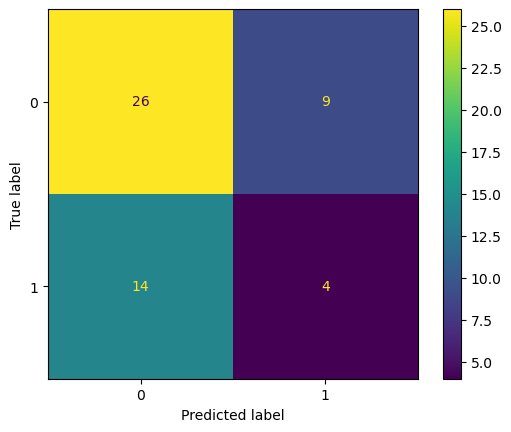

In [59]:
evaluate_model(gb_modelCV, scaled_X_test, y_test)

## Decision Tree

In [60]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
dt_model = DecisionTreeClassifier(random_state=101)
dt_model.fit(scaled_X_train, y_train)

DecisionTreeClassifier(random_state=101)


Classification Report:
               precision    recall  f1-score   support
0              0.657143  0.657143  0.657143  35.00000
1              0.333333  0.333333  0.333333  18.00000
accuracy       0.547170  0.547170  0.547170   0.54717
macro avg      0.495238  0.495238  0.495238  53.00000
weighted avg   0.547170  0.547170  0.547170  53.00000

AUC socre is: 0.49523809523809526



(array([0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0]),
               precision    recall  f1-score   support
 0              0.657143  0.657143  0.657143  35.00000
 1              0.333333  0.333333  0.333333  18.00000
 accuracy       0.547170  0.547170  0.547170   0.54717
 macro avg      0.495238  0.495238  0.495238  53.00000
 weighted avg   0.547170  0.547170  0.547170  53.00000,
 0.49523809523809526)

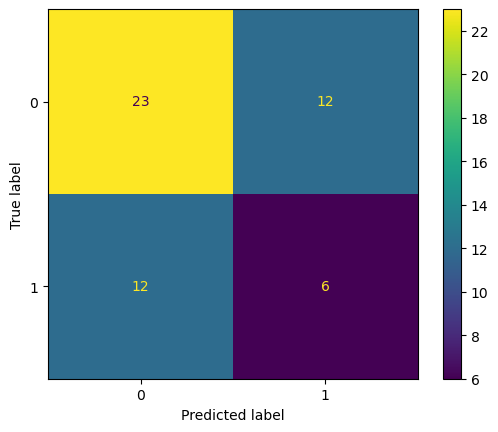

In [62]:
evaluate_model(dt_model, scaled_X_test, y_test)

## XGboost

In [63]:
import xgboost as xgb

In [64]:
xgb_model = xgb.XGBClassifier( eval_metric='logloss', random_state=101)
xgb_model.fit(scaled_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=101, ...)


Classification Report:
               precision    recall  f1-score    support
0              0.628571  0.628571  0.628571  35.000000
1              0.277778  0.277778  0.277778  18.000000
accuracy       0.509434  0.509434  0.509434   0.509434
macro avg      0.453175  0.453175  0.453175  53.000000
weighted avg   0.509434  0.509434  0.509434  53.000000

AUC socre is: 0.4936507936507937



(array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0]),
               precision    recall  f1-score    support
 0              0.628571  0.628571  0.628571  35.000000
 1              0.277778  0.277778  0.277778  18.000000
 accuracy       0.509434  0.509434  0.509434   0.509434
 macro avg      0.453175  0.453175  0.453175  53.000000
 weighted avg   0.509434  0.509434  0.509434  53.000000,
 0.4936507936507937)

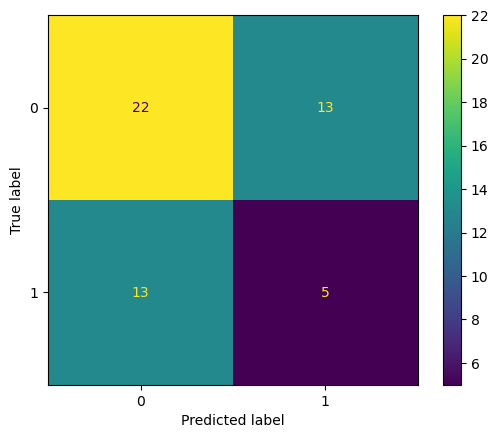

In [65]:
evaluate_model(xgb_model, scaled_X_test, y_test)

## Save the results to a excel file

In [66]:
model_scores = []
save_results('Logistic Regression',lr_model,scaled_X_test,y_test)
save_results('KNN',knnCV_model,scaled_X_test,y_test)
save_results('SVM',svm_modelCV,scaled_X_test,y_test)
save_results('Random Forest',rf_best,scaled_X_test,y_test)
save_results('AdaBoost',adaboost_model,scaled_X_test,y_test)
save_results('Gradient Boosting',gb_modelCV,scaled_X_test,y_test)
save_results('Decision Tree',dt_model,scaled_X_test,y_test)
save_results('XGBoost',xgb_model,scaled_X_test,y_test)



In [67]:
import os

In [68]:
results_df = pd.DataFrame(model_scores)

results_df.to_excel(os.path.join(config['output_dir']+'_'+config['target']+'.xlsx'), index=False)

# AutoGluon

In [69]:
# !pip install \
#    --no-binary lightgbm \
#    --config-settings=cmake.define.USE_OPENMP=OFF \
#    'lightgbm>=4.0.0'

In [70]:
#!python -m pip install autogluon

In [71]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [72]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [73]:
label =config['target']
predictor = TabularPredictor(label=label).fit(train_df)

No path specified. Models will be saved in: "AutogluonModels/ag-20240505_165712"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20240505_165712"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.8
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 

In [74]:
y_pred = predictor.predict(test_df)

In [75]:
predictor.evaluate(test_df)

{'accuracy': 0.4528301886792453,
 'balanced_accuracy': 0.3968253968253968,
 'mcc': -0.20377777622365403,
 'roc_auc': 0.4,
 'f1': 0.21621621621621623,
 'precision': 0.21052631578947367,
 'recall': 0.2222222222222222}

In [76]:
autogluon_result = predictor.leaderboard(test_df, extra_metrics=['precision','recall','f1','roc_auc'])

In [77]:
autogluon_result = autogluon_result.iloc[:,0:9]
autogluon_result

,model,score_test,precision,recall,f1,roc_auc,score_val,eval_metric,pred_time_test
0,LightGBMLarge,0.584906,0.409091,0.500000,0.450000,0.515873,0.806452,accuracy,0.003299
1,ExtraTreesEntr,0.566038,0.352941,0.333333,0.342857,0.452381,0.758065,accuracy,0.050516
2,XGBoost,0.547170,0.350000,0.388889,0.368421,0.542857,0.822581,accuracy,0.004617
3,NeuralNetFastAI,0.528302,0.294118,0.277778,0.285714,0.487302,0.790323,accuracy,0.012168
4,ExtraTreesGini,0.528302,0.315789,0.333333,0.324324,0.446825,0.774194,accuracy,0.022310
5,LightGBM,0.490566,0.200000,0.166667,0.181818,0.363492,0.838710,accuracy,0.004155
6,NeuralNetTorch,0.490566,0.200000,0.166667,0.181818,0.406349,0.774194,accuracy,0.012228
7,LightGBMXT,0.471698,0.187500,0.166667,0.176471,0.400000,0.854839,accuracy,0.005219
8,KNeighborsDist,0.471698,0.321429,0.500000,0.391304,0.557143,0.741935,accuracy,0.017545
9,RandomForestEntr,0.471698,0.187500,0.166667,0.176471,0.444444,0.806452,accuracy,0.022382


In [78]:
#save AutoGluon results to excel
autogluon_result.to_excel(os.path.join(config['output_dir']+'_'+config['target']+'AutoG'+'.xlsx'), index=False)

### Look at feature importance

In [79]:
import seaborn as sns

In [83]:
predictor.get_model_best()

'WeightedEnsemble_L2'

These features in provided data are not utilized by the predictor and will be ignored: ['original_firstorder_TotalEnergy']
Computing feature importance via permutation shuffling for 85 features using 310 rows with 5 shuffle sets...
	4.1s	= Expected runtime (0.82s per shuffle set)
	1.32s	= Actual runtime (Completed 5 of 5 shuffle sets)


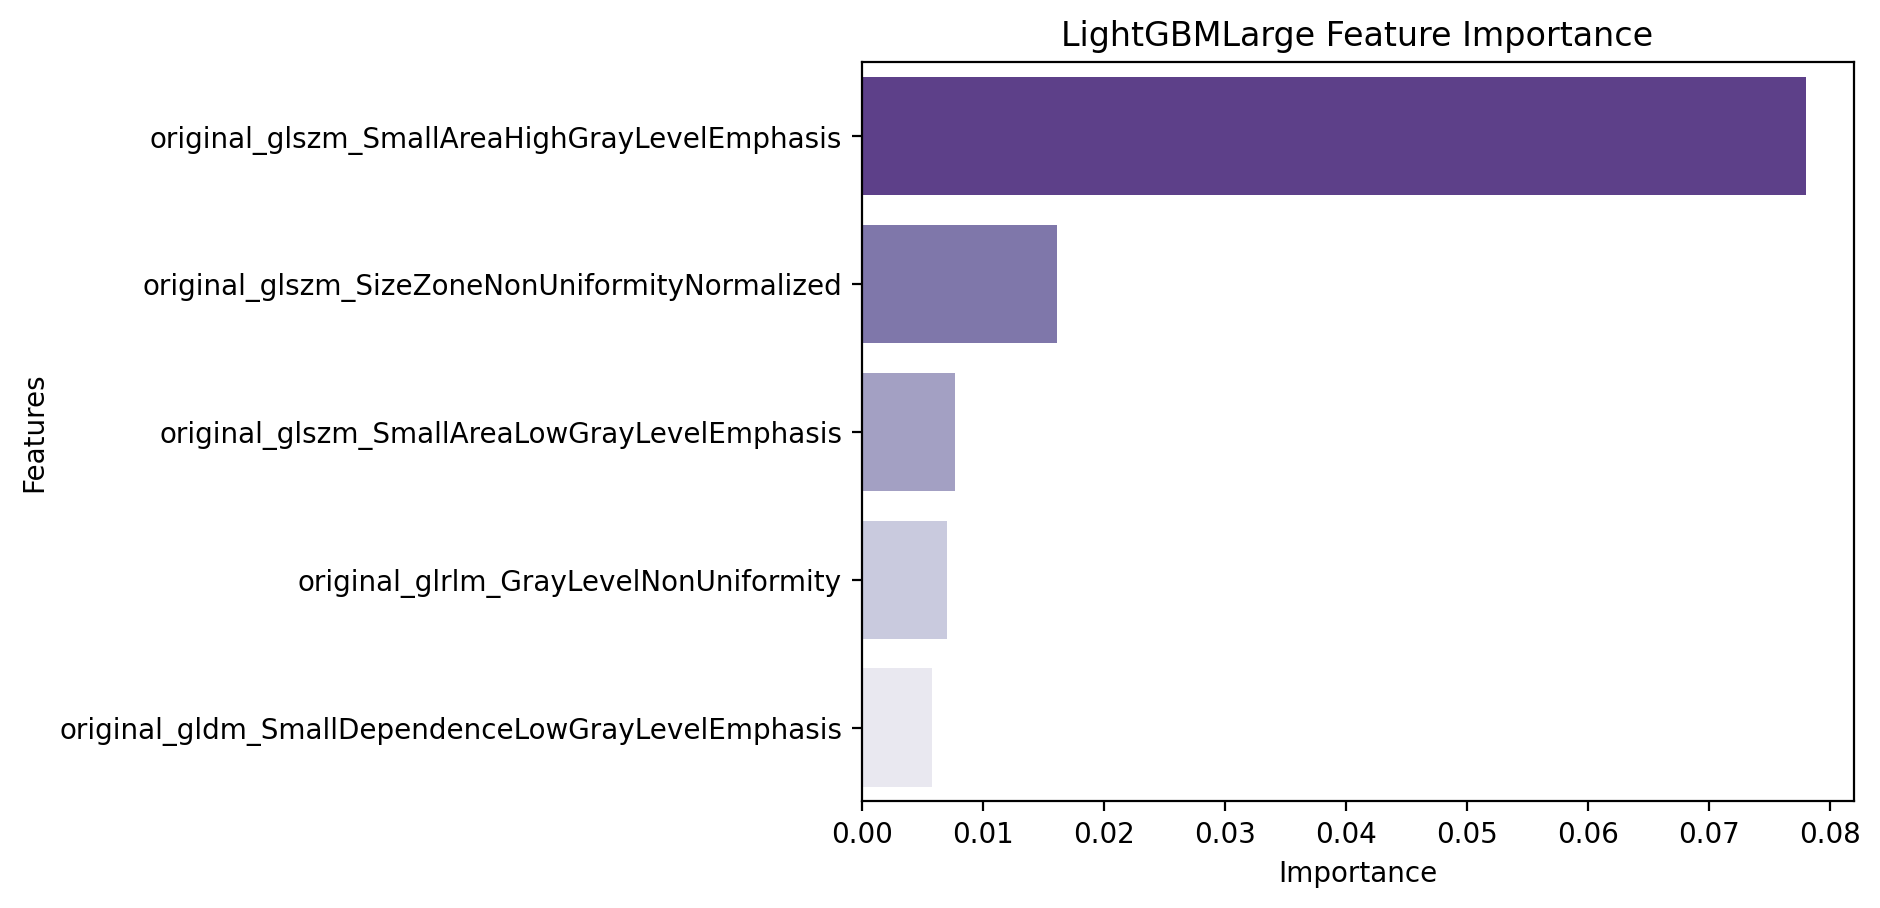

In [96]:
gluon_model = 'LightGBMLarge'
feature_importance = predictor.feature_importance(data=train_df, model=gluon_model)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance = feature_importance.nlargest(5,'importance')
plt.figure(dpi=200)
sns.barplot(x=feature_importance['importance'], y=feature_importance.index,palette='Purples_r')
plt.title(f'{gluon_model} Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

These features in provided data are not utilized by the predictor and will be ignored: ['original_firstorder_TotalEnergy']
Computing feature importance via permutation shuffling for 85 features using 310 rows with 5 shuffle sets...
	7.77s	= Expected runtime (1.55s per shuffle set)
	2.67s	= Actual runtime (Completed 5 of 5 shuffle sets)


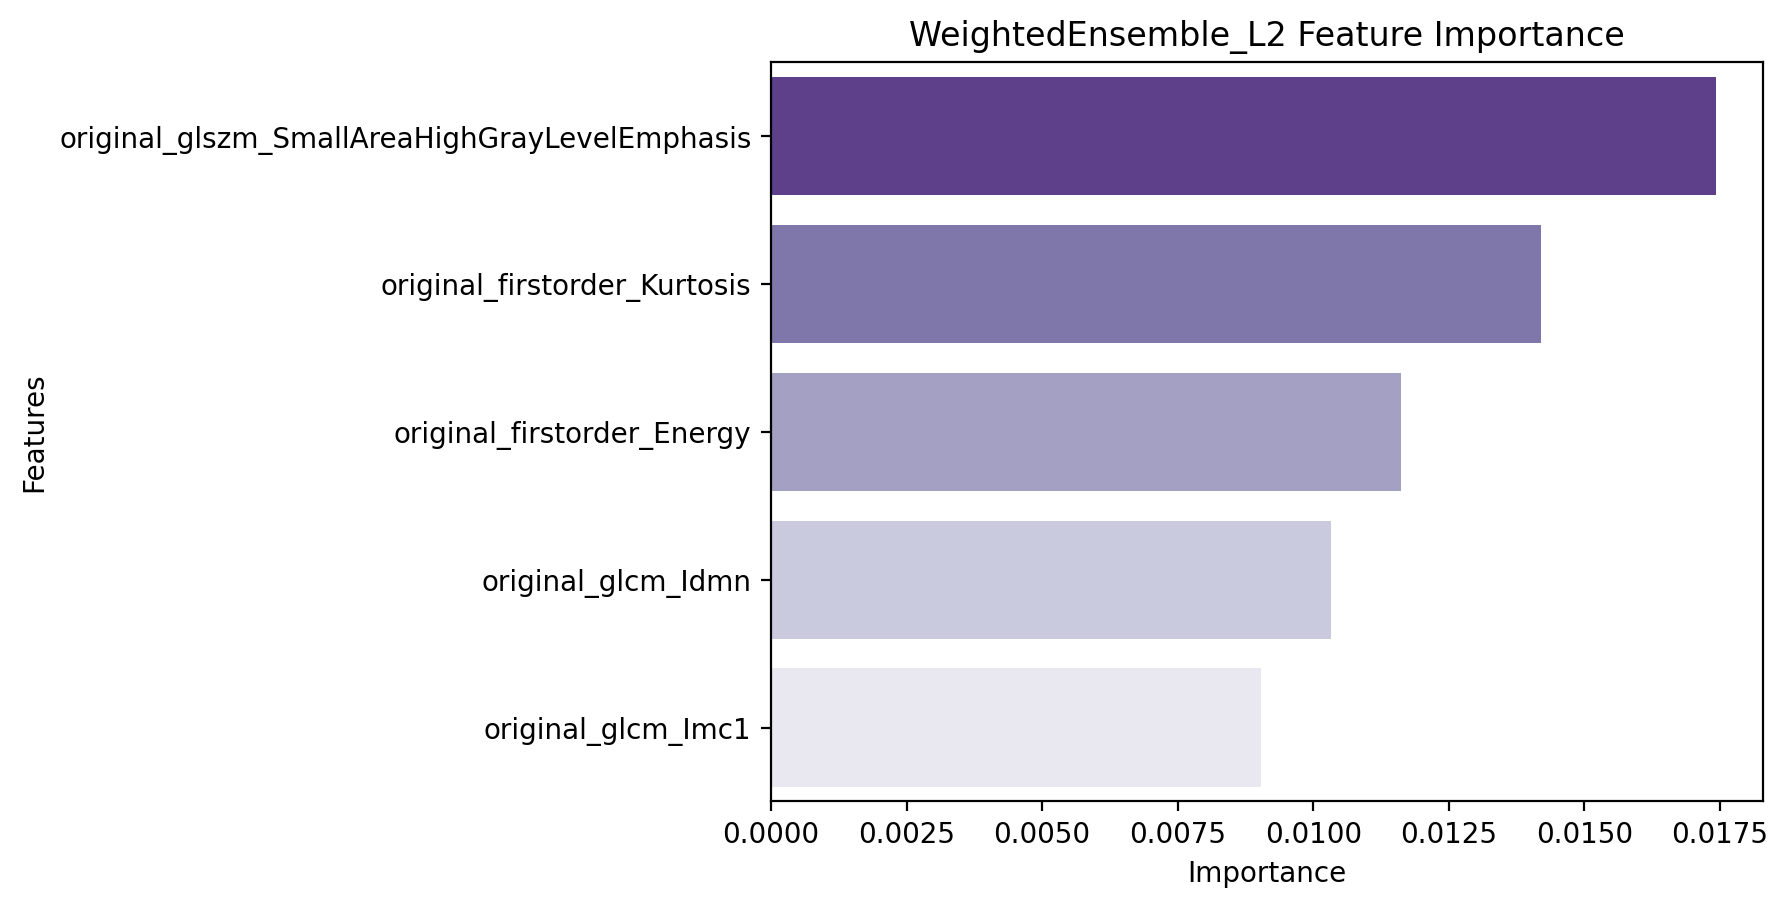

In [97]:
gluon_model = 'WeightedEnsemble_L2'
feature_importance = predictor.feature_importance(data=train_df, model=gluon_model)
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance = feature_importance.nlargest(5,'importance')
plt.figure(dpi=200)
sns.barplot(x=feature_importance['importance'], y=feature_importance.index,palette='Purples_r')
plt.title(f'{gluon_model} Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()